<font size=8> This is a demonstration of using Spark MLlib regression </font>

<font size="5"> Import Libraries, make sure SPARK_HOME is set before launching jupyter-notebook server </font>

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<font size="5"> You are likely need to install findspark that are needed to import pyspark.

To install it, run

pip install findspark
</font>

In [22]:
import findspark
findspark.init()
from __future__ import print_function

import os
import sys
import tempfile
import shutil

from pyspark.sql import SparkSession
from pyspark.mllib.stat import Statistics
from pyspark.mllib.util import MLUtils

<font size="5"> Generate 100 random values, under x, which is feature </font>

In [38]:
generate_random = np.random.RandomState(0)
x = 10 * generate_random.rand(100)

<font size="5"> Now create label y, wich is y=3X+"random value" </font>

In [40]:
y = 3 * x + np.random.randn(100)

<font size="5"> Scatter plot it, obviously data is linearly spreaded, because y=3x+"a fixed value" </font>

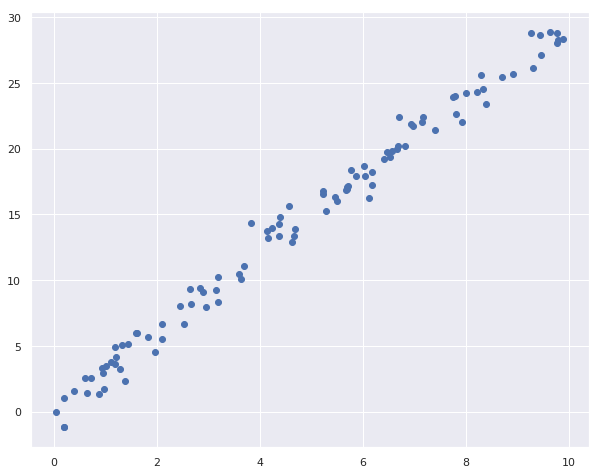

In [49]:
plt.figure(figsize = (10, 8))
plt.scatter(x, y);

<font size="5"> To create a Spark DataFrame called spdf, make a Pandas DataFrame df first </font>

In [50]:
frame={'x':list(x),'label':list(y)}
df=pd.DataFrame(frame)

In [51]:
spark = SparkSession \
    .builder \
    .appName("LinearRegression") \
    .getOrCreate()


In [52]:
spdf = spark.createDataFrame(df)

<font size="5"> Spark ML requires Spark DataFrame which feature is in the form of vector, entire feature, whether it is a single variable or multi variables need to be converted to vector, which can be assemble by VectorAssembler. Below, VectorAssembler converts a Spark DataFrame spdf into a Vectorized Spark DataFrame vector_df that is ready for machine learning </font>

In [53]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['x'], outputCol = 'features')
#vectorAssembler = VectorAssembler(inputCols = ['rm'], outputCol = 'features')
vector_df = vectorAssembler.transform(spdf)
vector_df = vector_df.select(['features', 'label'])
vector_df.show(3)

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[5.4881350392732475]|15.982827832054529|
| [7.151893663724195]|21.991431337490727|
| [6.027633760716439]|18.712632000336676|
+--------------------+------------------+
only showing top 3 rows



<font size="5"> As usual, ramdonly split trainging and testing to 70% and 30%, to have training DataFrame train_df and testing DataFrame test_df</font>

In [30]:
splits = vector_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]
print(test_df.count())

27


<font size="5"> Now using LinearRegression to fit the model with train_df, from the training, you can get coeffcients and intercept.
    coefficient in the linear equation is slope.
    You can construct the linear equation to
    
    y=coefficient*x+intercept


</font> 

In [54]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients[0]))
print("Intercept: " + str(lr_model.intercept))

Coefficients: 2.860563091091942
Intercept: 0.5529302314382621


<font size="5"> Get the training Root Mean Square Error (which is also called Standard Error) and R2 score value </font>

In [55]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.916585
r2: 0.988804


<font size="5"> Describe the train_df, showing the statistics about it </font>

In [56]:
train_df.describe().show()

+-------+--------------------+
|summary|               label|
+-------+--------------------+
|  count|                  73|
|   mean|  13.733303671236655|
| stddev|    8.72256281421606|
|    min|0.028418558863261056|
|    max|  30.175913669841023|
+-------+--------------------+



<font size="5"> Now test the model with test_df, get the Root Mean Square Error and R2 score </font>

In [57]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","label","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
|13.070388488157365|12.883897873095439| [4.375872112626925]|
| 13.75383854105211|15.457060400613624|[4.6147936225293185]|
|16.802203287046506| 16.64165426316115| [5.680445610939323]|
|17.795356893963422|18.108441537837212| [6.027633760716439]|
|19.029138837358683|19.842833083679896| [6.458941130666561]|
+------------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.985529


 <font size="5"> We can plot the trained model from the linear equation using coefficient and intercept provided by the model </font>

In [58]:
y_pred=lr_model.coefficients[0]*x+lr_model.intercept

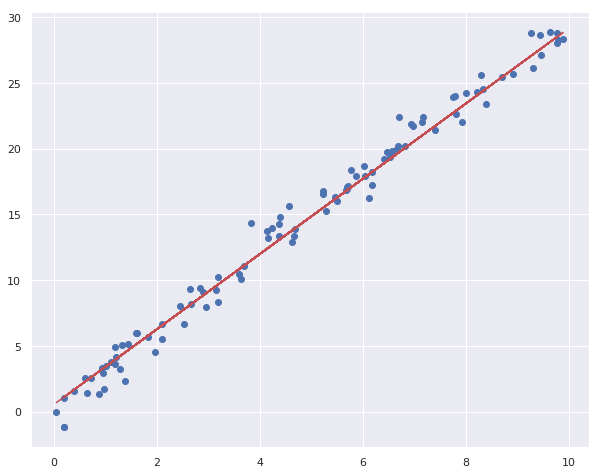

In [59]:
plt.figure(figsize = (10, 8))
plt.scatter(x, y);
plt.plot(x, y_pred,'r-');

<font size="5"> Line has pretty good fit amongst the scattered x values 

The bottom line, a regression model establishes an equation (linear or not), you can predict by plugging the x value to get the y value, which is your predict.

</font>